## Essentials

In [5]:
import numpy as np
from tqdm import tqdm
import xarray as xr
import subprocess
import os


In [2]:
from utils import DatasetPlotter, AreaPlotter, DataSet, Area, Station

In [3]:
# Get Grid info about soltau
station = Station("DWD_Soltau-04745", "Soltau")
# get lonlat info about soltau
lon, lat = station.get_lon_lat()
print(lon, lat, len(station.dataset.lon), len(station.dataset.lat))

grid_width = 8
grid_height = 8

9.793 52.96 1 1


---

In [1]:
era5 = DataSet("/work/bm1159/XCES/data4xces/reanalysis/reanalysis/ECMWF/IFS/ERA5/1hr/atmos/tas/r1i1p1/tas_1hr_reanalysis_era5_r1i1p1_20231001-20231031.nc", "era5", is_file=True)

# print nearest lon lat for testing
nearest_lon_idx, nearest_lat_idx = np.searchsorted(era5.lon, station.get_lon_lat())
print(nearest_lon_idx, nearest_lat_idx)
# print how solau lon is sorted in era5 lon
print(era5.lon[nearest_lon_idx-1:nearest_lon_idx+1], "->", f"{nearest_lon_idx-1}: {era5.lon[nearest_lon_idx-1]}, {nearest_lon_idx}: {era5.lon[nearest_lon_idx]}, {nearest_lon_idx+1}: {era5.lon[nearest_lon_idx+1]}")
print(f"{station.name}.lon is between {nearest_lon_idx - 1} and {nearest_lon_idx}")

lon_slice, lat_slice, area = era5.crop_grid(*station.get_lon_lat(), grid_width, grid_height)
print(lon_slice, lat_slice, area)

NameError: name 'DataSet' is not defined

In [5]:
# use grid to crop era5 data
era5_min_lon_idx, era5_max_lon_idx, _ = lon_slice.indices(len(era5.lon))
era5_min_lat_idx, era5_max_lat_idx, _ = lat_slice.indices(len(era5.lat))

lower_idxes = list(range(era5_min_lon_idx, nearest_lon_idx))
upper_idxes = list(range(nearest_lon_idx, era5_max_lon_idx))

print(f"{len(lower_idxes)}: {lower_idxes} - {station.get_lon_lat()[0]} - {upper_idxes}: {len(upper_idxes)}")

4: [31, 32, 33, 34] - 9.793 - [35, 36, 37, 38]: 4


In [6]:
from concurrent.futures import ProcessPoolExecutor

In [1]:


# use cdo selindexbox with subprocess

era5_source_dir = "/work/bm1159/XCES/data4xces/reanalysis/reanalysis/ECMWF/IFS/ERA5/1hr/atmos/tas/r1i1p1"
era5_cropped_dir = "era5_cropped"



all_files = os.listdir(era5_source_dir)
# sort files by name, start with the newes (highes number)
all_files.sort(reverse=True)

min_date = 19500101
max_date = 20231231

all_files = []
for file in os.listdir(era5_source_dir):
    if file.endswith(".nc"):
        date = int(file.split("_")[-1].split("-")[0])
        if min_date <= date <= max_date:
            all_files.append(file)


# remove direcotry if it exists
if os.path.exists(era5_cropped_dir):
    os.system(f"rm -rf {era5_cropped_dir}")

# if folder does not exist, create it
if not os.path.exists(era5_cropped_dir):
    os.mkdir(era5_cropped_dir)


def crop_and_copy_file(file, expected_lon_values=None, expected_lat_values=None):
    if not os.path.exists(f"{era5_cropped_dir}/{file}"):
        # cdo selindexbox with subprocess
        cdo_command = f"cdo selindexbox,{era5_min_lon_idx + 1},{era5_max_lon_idx},{era5_min_lat_idx + 1},{era5_max_lat_idx} {era5_source_dir}/{file} {era5_cropped_dir}/{file}"
        subprocess.run(cdo_command, shell=True)
    
    check_data = xr.open_dataset(f"{era5_cropped_dir}/{file}")

    lon_values_in_file = check_data.lon.values
    lat_values_in_file = check_data.lat.values
    
    check_data.close()

    try:

        assert expected_lon_values is None or np.array_equal(lon_values_in_file, expected_lon_values), f"lon values in file {file} are not as expected.\n" + \
        f"Expected:\n{expected_lon_values},\nbut got:\n{lon_values_in_file}"
        assert expected_lat_values is None or np.array_equal(lat_values_in_file, expected_lat_values), f"lat values in file {file} are not as expected.\n" + \
        f"Expected:\n{expected_lat_values},\nbut got:\n{lat_values_in_file}"
    
        return None

    except AssertionError as e:

        return file 



# Use tqdm to display a loading bar
with tqdm(total=len(all_files), desc="Processing Files", unit="file") as pbar:
    def update_progress(*args):
        pbar.update()


    with ProcessPoolExecutor(max_workers=32) as executor:
        futures = []
        for file in all_files:
            future = executor.submit(crop_and_copy_file, file, expected_lon_values=era5.lon[lon_slice], expected_lat_values=era5.lat[lat_slice])
            future.add_done_callback(update_progress)
            futures.append(future)

        # Wait for all tasks to complete
        problematic_files = [future.result() for future in futures if future.result() is not None]

# Print the filenames of problematic files
if problematic_files:
    print("Problematic files with grid differences:")
    for problematic_file in problematic_files:
        print(problematic_file)
else:
    print("No grid differences in files found.")

NameError: name 'os' is not defined

---

## Checkpoint

---

In [3]:
era5_for_soltau = DataSet(era5_cropped_dir, "era5_for_soltau", replace_existing=True)

# remove directory 
# os.system(f"rm -rf {era5_cropped_dir}")

NameError: name 'era5_cropped_dir' is not defined

In [9]:
# Demonstration of Timezone functionality
from datetime import datetime,  timedelta
from pytz import timezone

import random
start_date = datetime(1991, 10, 1)
end_date = datetime(2020, 10, 31)
random_date = start_date + (end_date - start_date) * random.random()

tz = timezone("Europe/Berlin")
print("in timezone:", tz)
print("at", random_date)
print("time difference:", tz.utcoffset(random_date))


in timezone: Europe/Berlin
at 2003-04-01 02:33:34.226104
time difference: 2:00:00


In [10]:
# Soltau start date
print("Soltau dataset is in utc time" if station.dataset.is_utc_time else "Soltau dataset is not in utc time")
print("Soltau start date:", station.dataset.start_date)
print("soltau time[0]:", station.dataset.time[0])
print("soltau time at index 0:", station.dataset.time_at_index(0))

print("----------------------")

print("converted to utc:")
print("utc time at index 0:", station.dataset.time_at_index(0))

Soltau dataset is not in utc time
Soltau start date: 1966-01-01 01:00:00
soltau time[0]: 0.0
soltau time at index 0: 1966-01-01 01:00:00
----------------------
Timezone for Soltau: Europe/Berlin
UTC offset for Soltau: 1.0 hours
converted to utc:
utc time at index 0: 1966-01-01 00:00:00


In [11]:
# find intersection of the sets of timesteps in soltau and era5
self = station.dataset
other = era5_for_soltau

In [12]:


# get the later start date
start_date = max(self.start_date, other.start_date)
# get the earlier end date
end_date = min(self.start_date + timedelta(seconds=self.time[-1] * self.units),
            other.start_date + timedelta(seconds=other.time[-1] * other.units))


print("start_date:", start_date)
print("end_date:", end_date)

# get the time indices for the intersection
self_start_idx = self.get_time_index(start_date)
self_end_idx = self.get_time_index(end_date)

other_start_idx = other.get_time_index(start_date)
other_end_idx = other.get_time_index(end_date)

assert self.time_at_index(self_start_idx) == other.time_at_index(other_start_idx), "start times are not equal"
assert self.time_at_index(self_end_idx) == other.time_at_index(other_end_idx), "end times are not equal"

self_invalid_times = self.find_invalid_values(start_time_idx=self_start_idx, end_time_idx=self_end_idx)
other_invalid_times = other.find_invalid_values(start_time_idx=other_start_idx, end_time_idx=other_end_idx)

start_date: 1966-01-01 00:00:00
end_date: 2022-12-31 22:00:00


Checking tas:  22%|██▏       | 111791/499654 [00:41<02:29, 2597.49it/s]

Checking tas: 100%|██████████| 499654/499654 [03:41<00:00, 2255.93it/s]


In [13]:
set_folder = "/work/bm1159/XCES/xces-work/k203179/data-sets"

if not os.path.exists(set_folder):
    os.mkdir(set_folder)

self_temp_path = f"{set_folder}/{self.name}_temp.nc"
other_temp_path = f"{set_folder}/{other.name}_temp.nc"
self_new_path = f"{self_temp_path.split('_temp')[0]}_cleaned.nc"
other_new_path = f"{other_temp_path.split('_temp')[0]}_cleaned.nc"
self_temp_path, other_temp_path

('/work/bm1159/XCES/xces-work/k203179/data-sets/Soltau_temp.nc',
 '/work/bm1159/XCES/xces-work/k203179/data-sets/era5_for_soltau_temp.nc')

In [14]:
# unique union of invalid times
self_delete_idx = np.concatenate((self_invalid_times, other_invalid_times - other_start_idx))
other_delete_idx = np.concatenate((other_invalid_times, self_invalid_times - self_start_idx))

self_delete_idx = np.unique(self_delete_idx)
other_delete_idx = np.unique(other_delete_idx)


if os.path.exists(self_temp_path):
    os.remove(self_temp_path)
# delete leading and trailing times outside of intersection
cdo_command = f"cdo seltimestep,{self_start_idx + 1}/{self_end_idx} {self.path} {self_temp_path}"
subprocess.run(cdo_command, shell=True)


if os.path.exists(other_temp_path):
    os.remove(other_temp_path)
cdo_command = f"cdo seltimestep,{other_start_idx + 1}/{other_end_idx} {other.path} {other_temp_path}"
subprocess.run(cdo_command, shell=True)


# delete invalid times

if os.path.exists(self_new_path):
    os.remove(self_new_path)
cdo_command = f"cdo delete,timestep={','.join(map(str, self_delete_idx))} {self_temp_path} {self_new_path}"
subprocess.run(cdo_command, shell=True)
os.remove(self_temp_path)



if os.path.exists(other_new_path):
    os.remove(other_new_path)
cdo_command = f"cdo delete,timestep={','.join(map(str, other_delete_idx))} {other_temp_path} {other_new_path}"
subprocess.run(cdo_command, shell=True)
os.remove(other_temp_path)

In [2]:
try:
    print(self_new_path, other_new_path)
   # raise Exception
except:
    self_new_path = "/work/bm1159/XCES/xces-work/k203179/data-sets/Soltau_cleaned.nc"
    other_new_path = "/work/bm1159/XCES/xces-work/k203179/data-sets/era5_for_soltau_cleaned.nc"

    print(self_new_path, other_new_path)

if os.path.exists("/work/bm1159/XCES/xces-work/k203179/data"):
    os.system(f"rm -rf /work/bm1159/XCES/xces-work/k203179/data")

from station_reconstruct_utils import TrainingsFilePair
tfp = TrainingsFilePair(self_new_path, other_new_path)
tfp.val = 160

tfp.prepare_trainings_files()

/work/bm1159/XCES/xces-work/k203179/data-sets/Soltau_cleaned.nc /work/bm1159/XCES/xces-work/k203179/data-sets/era5_for_soltau_cleaned.nc


preparing /work/bm1159/XCES/xces-work/k203179/data/test/Soltau_cleaned.nc: 100%|██████████| 8761/8761 [00:04<00:00, 1868.20it/s]
preparing /work/bm1159/XCES/xces-work/k203179/data/val/Soltau_cleaned.nc: 100%|██████████| 160/160 [00:00<00:00, 1852.58it/s]
preparing /work/bm1159/XCES/xces-work/k203179/data/train/Soltau_cleaned.nc:  23%|██▎       | 114761/499494 [01:06<03:40, 1748.09it/s]

In [16]:
cdo = f"cdo sinfo /work/bm1159/XCES/xces-work/k203179/data/test/era5_for_soltau_cleaned.nc"
subprocess.run(cdo, shell=True)

   File format : NetCDF4
    -1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter ID
     1 : ECMWF    unknown  v instant       1   1        64   1  F32  : 167.128       
   Grid coordinates :
     1 : gaussian                 : points=64 (8x8)  F320
                              lon : 8.71875 to 10.6875 by 0.28125 degrees_east
                              lat : 51.85009 to 53.81731 degrees_north
                        available : cellbounds
   Vertical coordinates :
     1 : surface                  : levels=1
   Time coordinate :
                             time : 8761 steps
     RefTime =  1950-01-01 00:00:00  Units = hours  Calendar = proleptic_gregorian
  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss
  2013-12-31 22:00:00  2013-12-31 23:00:00  2014-01-01 00:00:00  2014-01-01 01:00:00
  2014-01-01 02:00:00  2014-01-01 03:00:00  2014-01-01 04:00:00  2014-01-01 05:00:00
  2014-01-01 06:00:00  2014-01-01 07:00:00  2014-01

CompletedProcess(args='cdo sinfo /work/bm1159/XCES/xces-work/k203179/data/test/era5_for_soltau_cleaned.nc', returncode=0)

In [1]:
import xarray as xr
import numpy as np
import os
# open test dataset
file_path_test_set = "/work/bm1159/XCES/xces-work/k203179/data/test/expected_Soltau_cleaned.nc"
os.system(f"cp {file_path_test_set} {file_path_test_set.split('.nc')[0]}_reality.nc") 
test_set = xr.open_dataset(file_path_test_set)

# set all tas values to null
test_set.tas.values[:] = np.nan

# save changes force overwrite via deletion of existing file
os.remove(file_path_test_set)
test_set.to_netcdf(file_path_test_set)

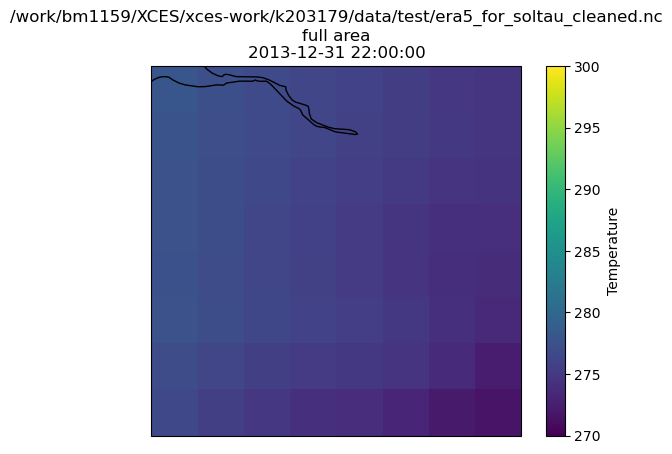

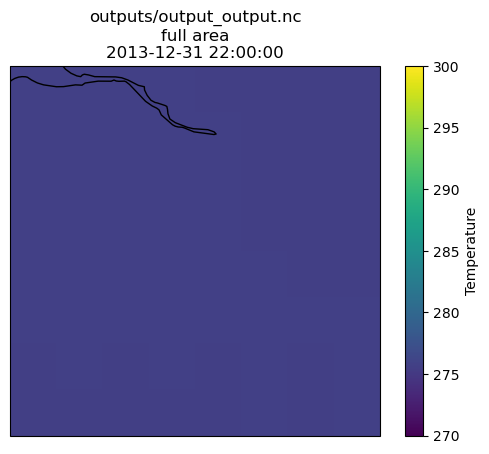

In [9]:
from station_reconstruct_utils import DataSet, DatasetPlotter

vmin = 270
vmax = 300


soltau_input = DatasetPlotter(DataSet("/work/bm1159/XCES/xces-work/k203179/data/test/era5_for_soltau_cleaned.nc", "input", is_file=True))
soltau_input.vmin = vmin
soltau_input.vmax = vmax
soltau_input.plot()



era5_train = DatasetPlotter(DataSet("outputs/output_output.nc", "output", is_file=True))
era5_train.vmin = vmin
era5_train.vmax = vmax
era5_train.plot()

# Clean the Test Dataset values to NAN